In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""   Analyse simulations   -- Version 2.0
Last edit:  2023/07/07
Authors:    Leone, Riccardo (RL)
Notes:      - Evaluate the different combinations of b and w
            - Release notes:
                * Reformatted everything for plotting with seaborn
                * Restructured to be more easy to follow
To do:      - 
Comments:   

Sources: 
"""

'   Analyse simulations   -- Version 1.1\nLast edit:  2023/06/12\nAuthors:    Leone, Riccardo (RL)\nNotes:      - Evaluate the different combinations of b and w\n            - Release notes:\n                * \nTo do:      - \nComments:   \n\nSources: \n'

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from petTOAD_setup import *

Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


## Imports

In [3]:
EXPL_DIR = RES_DIR / "exploratory_ws_-0.1-0.1_bs_-0.025-0.025"
EXPL_RAND_DIR = RES_DIR / "exploratory_ws_-0.1-0.1_bs_-0.025-0.025_random"
EXPL_SC_DIR = RES_DIR / "exploratory_sc_disconn"
EXPL_G_DIR = RES_DIR / "exploratory_G-weight_ws_-1-1_bs_-0.8-0.08"
EXPL_G_RAND_DIR = RES_DIR / "exploratory_G-weight_ws_-1-1_bs_-0.8-0.08_random"
EXPL_HET_DIR = RES_DIR / "exploratory_heterogeneous_ws_0.05-0.15_bs_-0.025-0.025"
EXPL_FIG_DIR = EXPL_DIR / "Figures"
if not Path.exists(EXPL_FIG_DIR):
    Path.mkdir(EXPL_FIG_DIR)
MCI_DIR = RES_DIR / "model_simulations" / "MCI_noWMH"

## Define useful functions

In [15]:
def annotate_star(tbl):
    """
    This function is just to plot a start at the best heatmap value for better recognition
    """
    star = tbl.where(tbl == tbl.values.max())
    star = star.replace({np.nan: ""})
    star = star.replace({tbl.values.max(): "*"})
    return star


def get_best_dfs(big_df, fc_name, phfcd_name):
    # Get the best model fits for fc, phfcd for each subject and create one single df (skip fcd for now)
    res_df_best = pd.DataFrame(
        {
            fc_name: big_df.groupby(["PTID"])[fc_name].max(),
            phfcd_name: big_df.groupby(["PTID"])[phfcd_name].max(),
        }
    ).reset_index()

    res_df_best["wmh_load"] = [wmh_dict[subj] for subj in res_df_best["PTID"]]
    # This df is to check what are the best w, b in case of the best fc and best phfcd
    # First we group by each patient and get the max fc pearson for each
    # Then we merge this df (with the name of pt and max fc) with the df containing also b and w
    # so we have: max(FC), b, w for each patient
    max_fc_vals = big_df.groupby(["PTID"])[fc_name].max().reset_index()
    merged_df_max_fc = pd.merge(big_df, max_fc_vals, on=["PTID", fc_name])
    # We do the same for 1-phFCD
    max_phfcd_vals = big_df.groupby(["PTID"])[phfcd_name].max().reset_index()
    merged_df_max_phfcd = pd.merge(big_df, max_phfcd_vals, on=["PTID", phfcd_name])

    return merged_df_max_fc, merged_df_max_phfcd


def plot_parm_best_wmh_relationship(parm):
    """
    This function plots the relationship between the best achieved FC and (1-phFCD) and WMH (normalized) in the parameter space that was explored
    """
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    # Values that give the best FC
    sns.regplot(
        ax=axs[0, 0], data=df_max_fc_a, x="wmh_load", y=parm, color="green", label="All"
    )

    sns.regplot(
        ax=axs[0, 1],
        data=df_max_fc_a[df_max_fc_a["PTID"].isin(HC_WMH)],
        x="wmh_load",
        y=parm,
        label="HC WMH",
    )
    sns.regplot(
        ax=axs[0, 1],
        data=df_max_fc_a[df_max_fc_a["PTID"].isin(MCI_WMH)],
        x="wmh_load",
        y=parm,
        label="MCI WMH",
    )
    axs[0, 0].set_ylabel(f"{parm} (best FC)")
    axs[0, 1].set_ylabel(f"{parm} (best FC)")

    # Values that give the best phFCD
    sns.regplot(ax=axs[1, 0], data=df_max_phfcd_a, x="wmh_load", y=parm, color="green")
    sns.regplot(
        ax=axs[1, 1],
        data=df_max_phfcd_a[df_max_phfcd_a["PTID"].isin(HC_WMH)],
        x="wmh_load",
        y=parm,
    )
    sns.regplot(
        ax=axs[1, 1],
        data=df_max_phfcd_a[df_max_phfcd_a["PTID"].isin(MCI_WMH)],
        x="wmh_load",
        y=parm,
    )
    axs[1, 0].set_ylabel(f"{parm} (best phFCD)")
    axs[1, 1].set_ylabel(f"{parm} (best phFCD)")

    fig.legend()
    fig.tight_layout()


def save_plot_results(res_df, group, random):
    """
    This function starts from the results dataframe, converts it into a pivot-table, which is what seaborn need to plot the heatmap.
    It does so both for fc and for phfcd. Also plots and saves the results.
    """

    # Convert the result df into a pivot table so to plot heatmap
    table_fc = pd.pivot_table(
        res_df, values="fc_pearson", index="b", columns="w"
    ).astype(float)
    # Skip fcd for now
    # table_fcd = pd.pivot_table(res_df, values='fcd_ks', index='b', columns='w').astype(float)
    table_phfcd = pd.pivot_table(
        res_df, values="phfcd_ks", index="b", columns="w"
    ).astype(float)
    # Create a composite score by summing up the single model fits so to choose when FC and phFCD have different "best" b-w combinations
    table_sum = table_fc + table_phfcd
    # Create Heatmaps
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    sns.heatmap(
        ax=axs[0],
        data=table_fc,
        annot=annotate_star(table_fc),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[0].set_title(f"FC", fontsize=9)

    # Still skip fcd for now
    # sns.heatmap(ax = axs[0,1],
    #             data = table_fcd,
    #             annot = annotate_star(table_fcd),
    #             fmt = '',
    #             annot_kws={"size": 10})
    # axs[0,1].set_title(f"FCD {group}")

    sns.heatmap(
        ax=axs[1],
        data=table_phfcd,
        annot=annotate_star(table_phfcd),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[1].set_title(f"1 - phFCD", fontsize=9)
    sns.heatmap(
        ax=axs[2],
        data=table_sum,
        annot=annotate_star(table_sum),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[2].set_title(f"FC + (1 - phFCD)", fontsize=9)
    if not random:
        savename = f"{group}_results_heatmap.png"
        fig.suptitle(f"{group} Random = False")
    else:
        savename = f"{group}_results_heatmap_random.png"
        fig.suptitle(f"{group} Random = True")
    fig.tight_layout()
    plt.savefig(EXPL_FIG_DIR / savename)


def perform_group_analyses(adnimerge, big_df, group, random):
    """
    This function allow us to select the grouping classification (Fazekas 1, Fazekas 2 or all) as the 'group'variable and then it selects
    only HC and MCI with WMH based on the chosen classification (since we are not interested for this type of model in patients without WMH).
    Then, calls the save_plot_results function, which plots and saves a summary heatmap of the mean FC and 1-phFCD across all patients that fall
    into a category (HC or MCI) according to the chosen grouping.

    Args:
        adnimerge:
        big_df:
        group:
        random:

    Returns:
        Nothing
    """
    if group == "Group_bin":
        # This is a convenience way to not to have to rewrite the whole function...
        # Of course, in this specific case, even if the variables are called HC_WMH and MCI_WMH, we are dealing with the whole group
        HC_WMH = adnimerge[adnimerge[group] == "CN"]["PTID"]
        MCI_WMH = adnimerge[adnimerge[group] == "MCI"]["PTID"]
    else:
        HC_WMH = adnimerge[adnimerge[group] == "CN_WMH"]["PTID"]
        MCI_WMH = adnimerge[adnimerge[group] == "MCI_WMH"]["PTID"]

    # HC_no_WMH = adnimerge[adnimerge[group] == 'CN_no_WMH']['PTID']
    # hc_no_wmh_df = big_df[big_df['PTID'].isin(HC_no_WMH)]
    # hc_no_wmh_grouped = hc_no_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    # save_plot_results(hc_no_wmh_grouped, "hc_no_wmh_Fazekas_1.0")

    hc_wmh_df = big_df[big_df["PTID"].isin(HC_WMH)]
    hc_wmh_grouped = hc_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    save_plot_results(hc_wmh_grouped, f"hc_wmh_{group}", random)

    # MCI_no_WMH = adnimerge[adnimerge[group] == 'MCI_no_WMH']['PTID']
    # mci_no_wmh_df = big_df[big_df['PTID'].isin(MCI_no_WMH)]
    # mci_no_wmh_grouped = mci_no_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    # save_plot_results(mci_no_wmh_grouped, "mci_no_wmh_Fazekas_1.0")

    mci_wmh_df = big_df[big_df["PTID"].isin(MCI_WMH)]
    mci_wmh_grouped = mci_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    save_plot_results(mci_wmh_grouped, f"mci_wmh_{group}", random)


def plot_compare_grouping(joined_compare_df, order, title, savename):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    sns.boxplot(
        ax=axs[0],
        data=joined_compare_df,
        x="values",
        y="fc_pearson",
        hue="group",
        order=order,
    )
    axs[0].set_ylabel("PCC")
    sns.boxplot(
        ax=axs[1],
        data=joined_compare_df,
        x="values",
        y="phfcd_ks",
        hue="group",
        order=order,
    )
    axs[1].set_ylabel("1 - KS")
    sns.boxplot(
        ax=axs[2],
        data=joined_compare_df,
        x="values",
        y="summed_fc_phfcd",
        hue="group",
        order=order,
    )
    axs[2].set_ylabel("PCC + (1 - KS)")
    fig.suptitle(title)
    plt.savefig(EXPL_FIG_DIR / savename)
    plt.show()
    fig.tight_layout()


def select_b_w_combo(df_boxplot_long, w1, b1, w2, b2, groupname1, groupname2):
    compare_df1 = df_boxplot_long[
        (df_boxplot_long["w"] == w1) & (df_boxplot_long["b"] == b1)
    ]
    compare_df1 = compare_df1[compare_df1["group"] == groupname1]
    compare_df2 = df_boxplot_long[
        (df_boxplot_long["w"] == w2) & (df_boxplot_long["b"] == b2)
    ]
    compare_df2 = compare_df2[compare_df2["group"] == groupname2]
    joined_compare_df = pd.concat([compare_df1, compare_df2])
    return compare_df1, compare_df2, joined_compare_df

## Prepare data

In [6]:
# Same reduced list as the exploratory simulations
short_subjs = HC_WMH[:30]
short_subjs = np.append(short_subjs, HC_no_WMH[:30])
short_subjs = np.append(short_subjs, MCI_no_WMH[:30])
short_subjs = np.append(short_subjs, MCI_WMH[:30])
# Load wmh dictionary
wmh_dict = get_wmh_load_homogeneous(short_subjs)
# Create overall dfs for each model and populate them with single subject results
df_a_big = pd.DataFrame()
df_a_rand_big = pd.DataFrame()
df_sc_big = pd.DataFrame()
df_G_big = pd.DataFrame()
df_G_rand_big = pd.DataFrame()
df_het_big = pd.DataFrame()

# We loop through every subject
for subj in short_subjs:
    # we read the csv of saved results for each subject for all models
    df_a = pd.read_csv(
        EXPL_DIR / f"sub-{subj}_df_results_initial_exploration_wmh.csv", index_col=0
    )
    df_a_rand = pd.read_csv(
        EXPL_RAND_DIR / f"sub-{subj}_df_results_initial_exploration_wmh.csv",
        index_col=0,
    )
    df_sc = pd.read_csv(
        EXPL_SC_DIR / f"sub-{subj}_df_results_initial_exploration_wmh.csv", index_col=0
    )
    df_G = pd.read_csv(
        EXPL_G_DIR / f"sub-{subj}_df_results_initial_exploration_wmh_G.csv", index_col=0
    )
    df_G_rand = pd.read_csv(
        EXPL_G_RAND_DIR / f"sub-{subj}_df_results_initial_exploration_wmh_G.csv", index_col=0
    )

    # Set the PTID column == to this subject
    df_a["PTID"] = subj
    df_a_rand["PTID"] = subj
    df_sc["PTID"] = subj
    df_G["PTID"] = subj
    df_G_rand["PTID"] = subj

    # Get the wmh load for this subject
    df_a["wmh_load"] = wmh_dict[subj]
    df_G["wmh_load"] = wmh_dict[subj]

    # Since the heterogeneous models sometimes gave some nans, we try, except to load it
    try:
        df_het = pd.read_csv(
            EXPL_HET_DIR / f"sub-{subj}_df_results_initial_exploration_wmh_G.csv",
            index_col=0,
        )
        df_het["PTID"] = subj
        df_het_big = pd.concat([df_het_big, df_het], ignore_index=True)
    except:
        continue
    finally:
        # we concatenate results of all subjects and create model-specific datasets with all patients
        df_a_big = pd.concat([df_a_big, df_a], ignore_index=True)
        df_a_rand_big = pd.concat([df_a_rand_big, df_a_rand], ignore_index=True)
        df_sc_big = pd.concat([df_sc_big, df_sc], ignore_index=True)
        df_G_big = pd.concat([df_G_big, df_G], ignore_index=True)
        df_G_rand_big = pd.concat([df_G_rand_big, df_G_rand], ignore_index=True)

# Then, we convert phfcd to 1-phfcd so to have higher numbers = better fits
df_a_big["phfcd_ks"] = 1 - df_a_big["phfcd_ks"]
df_a_rand_big["phfcd_ks"] = 1 - df_a_rand_big["phfcd_ks"]
df_sc_big["phfcd_ks"] = 1 - df_sc_big["phfcd_ks"]
df_G_big["phfcd_ks"] = 1 - df_G_big["phfcd_ks"]
df_G_rand_big["phfcd_ks"] = 1 - df_G_rand_big["phfcd_ks"]
df_het_big["phfcd_ks"] = 1 - df_het_big["phfcd_ks"]

# Load the clinical dataframe with the groupings
adnimerge = pd.read_csv(RES_DIR / "petTOAD_dataframe.csv")
adnimerge["PTID"] = adnimerge["PTID"].str.replace("_", "")
adnimerge = adnimerge.rename(columns={"Group_bin_Fazekas": "Group_Fazekas_2.0"})
adnimerge["Group_Fazekas_1.0"] = np.where(
    adnimerge["Fazekas_periventricular"] + adnimerge["Fazekas_lobar"] < 2,
    adnimerge["Group_bin"] + "_no_WMH",
    adnimerge["Group_bin"] + "_WMH",
)

# Prepare databases with the maximum values for each type of model
df_max_fc_a, df_max_phfcd_a = get_best_dfs(df_a_big, "fc_pearson", "phfcd_ks")
df_max_fc_a_rand, df_max_phfcd_a_rand = get_best_dfs(df_a_rand_big, "fc_pearson", "phfcd_ks")
df_max_fc_sc, df_max_phfcd_sc = get_best_dfs(df_sc_big, "fc_pearson", "phfcd_ks")
df_max_fc_G, df_max_phfcd_G = get_best_dfs(df_G_big, "fc_pearson", "phfcd_ks")
df_max_fc_G_rand, df_max_phfcd_G_rand = get_best_dfs(df_G_rand_big, "fc_pearson", "phfcd_ks")
df_max_fc_hetero, df_max_phfcd_hetero = get_best_dfs(
    df_het_big, "fc_pearson", "phfcd_ks"
)
df_base = df_a_big[(df_a_big["w"] == 0) & (df_a_big["b"] == 0)]

First, we want to check that:
1. The model is working as expected, so we plot the best possible fc and best possible phfcd for each subject:
2. If there is any relationship between the best achievable fc and phfcd and the wmh load (for example, does the model completely derange when there are a lot of WMH?)

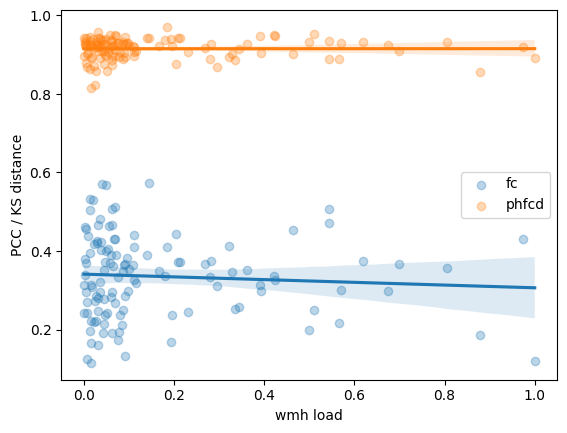

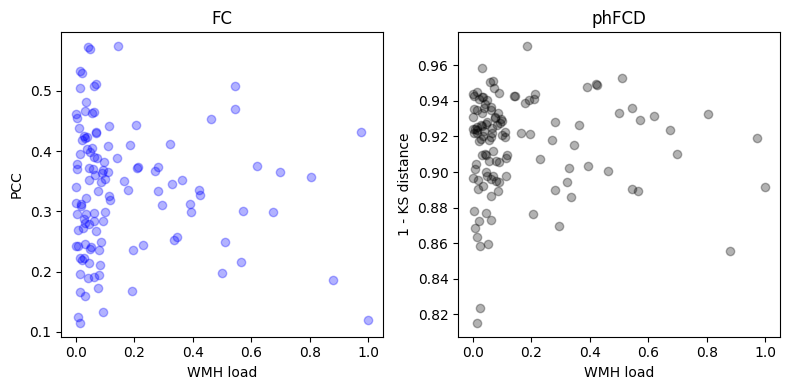

In [11]:
# Plot relationship between best overall model fits in this simulation and wmh load
# Here, all together, with regression
plt.figure()
ax1 = sns.regplot(
    data=df_max_fc_a,
    y="fc_pearson",
    x="wmh_load",
    order=1,
    scatter_kws={"alpha": 0.3},
    label="fc",
)
# ax2 = sns.regplot(res_df_best, y = 'fcd_ks', x = 'wmh_load', order = 2, scatter_kws={'alpha':0.3}, label = 'fcd')
ax3 = sns.regplot(
    data=df_max_phfcd_a,
    y="phfcd_ks",
    x="wmh_load",
    order=1,
    scatter_kws={"alpha": 0.3},
    label="phfcd",
)
ax3.set(ylabel="PCC / KS distance", xlabel="wmh load")
plt.legend()
plt.show()
plt.savefig(EXPL_FIG_DIR / "summary_best_values_regression.png")
plt.close()
# Here, separate, only with points
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
axs[0].plot(df_max_fc_a["wmh_load"], df_max_fc_a["fc_pearson"], "bo", alpha=0.3)
axs[0].set_ylabel("PCC")
axs[0].set_xlabel("WMH load")
axs[0].set_title("FC")
# axs[1].plot(res_df_best['wmh_load'], res_df_best['fcd_ks'], 'go', alpha = 0.3)
# axs[1].set_ylabel('1 - KS distance')
# axs[1].set_title('FCD')
axs[1].plot(df_max_phfcd_a["wmh_load"], df_max_phfcd_a["phfcd_ks"], "ko", alpha=0.3)
axs[1].set_ylabel("1 - KS distance")
axs[1].set_xlabel("WMH load")
axs[1].set_title("phFCD")
fig.tight_layout()
plt.savefig(EXPL_FIG_DIR / "summary_best_values_points.png")

It seems that for the vast majority of patients the best achievable fc and phfcd are high, as expected... there might be 2 patients for whom the empirical data might be corrupted or the model fails with the chosen parameters, but overall it seems that we can achieve fairly good fits. Also, from the regression lines, it seems that we can achieve the same maximum fit independently of the wmh load.

Now we ask ourselves, what are the values of a (obtained from the given combination of best w and best b) that give the best results? 

In [13]:
# Calculate the best a from the best w and the best b
df_max_fc_a["a"] = -0.02 + df_max_fc_a["w"] * df_max_fc_a["wmh_load"] + df_max_fc_a["b"]
df_max_phfcd_a["a"] = (
    -0.02 + df_max_phfcd_a["w"] * df_max_phfcd_a["wmh_load"] + df_max_phfcd_a["b"]
)

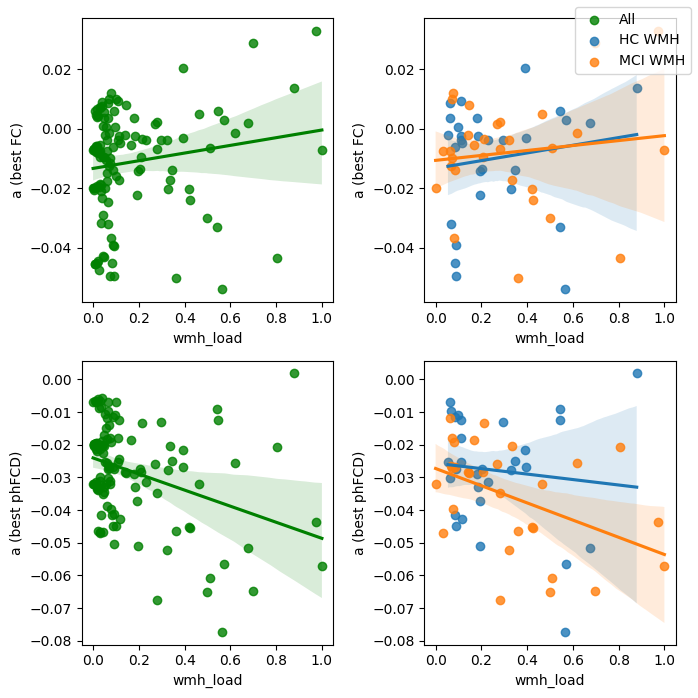

In [16]:
# Plot the relationship with the a
plot_parm_best_wmh_relationship("a")
# Plot the relationship with the b
# plot_parm_best_wmh_relationship("b")
# Plot the relationship with the w
# plot_parm_best_wmh_relationship("w")

## Analyses

### Fazekas 1 vs. Fazekas 2 vs No Grouping

The following are analyses aggregating patients with different diagnosis (HC, MCI) belonging to the WMH according to different classifications (Fazekas 1 or 2).
In this section we want to see whether there are differences amongst model performance if we use different criteria to classify patients as WMH / non WMH, namely Fazekas of 1 or Fazekas of 2, or if we just don't classify them and use all CN and all MCI.

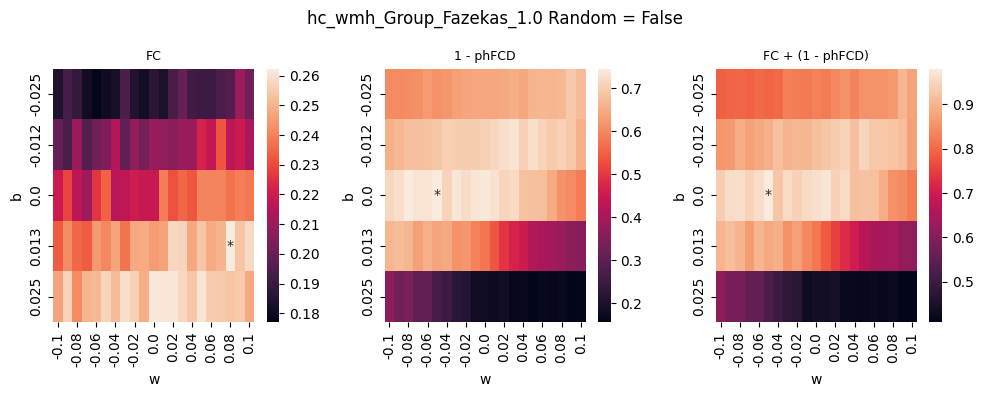

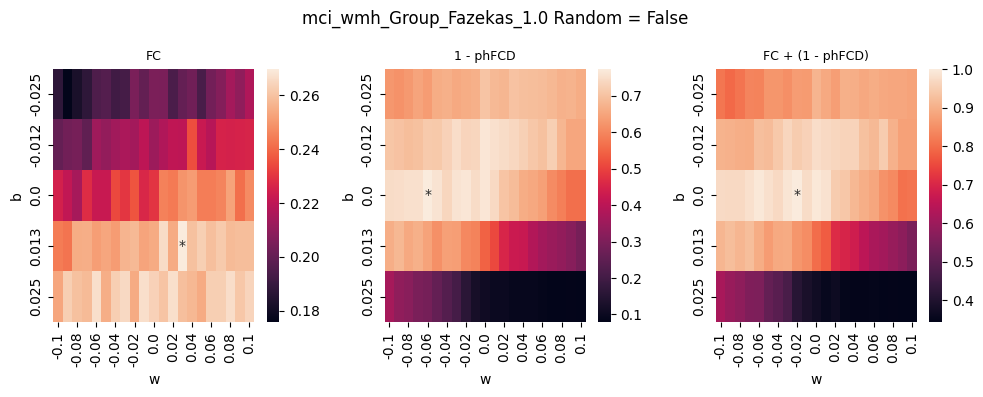

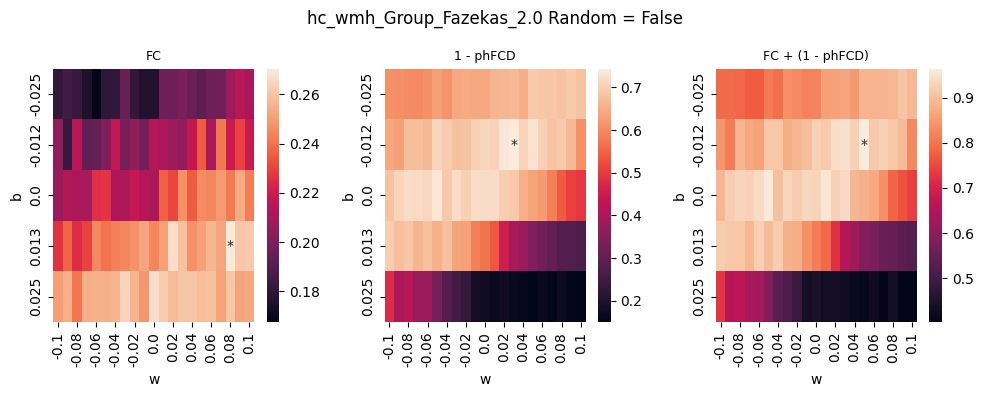

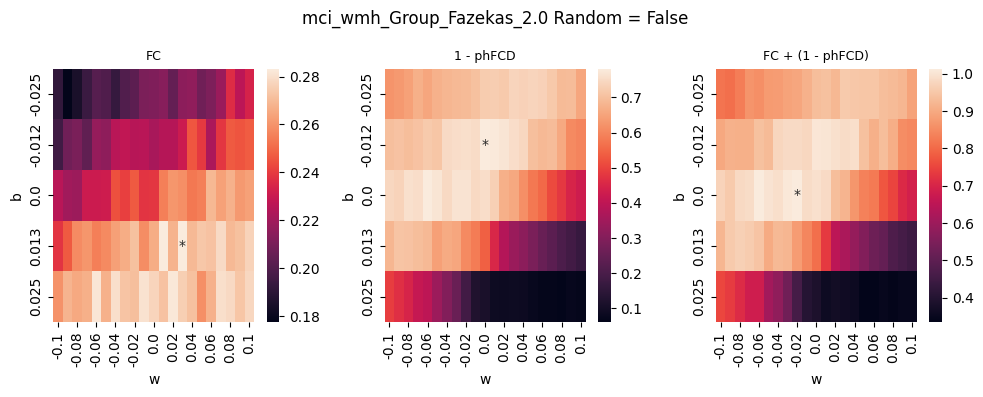

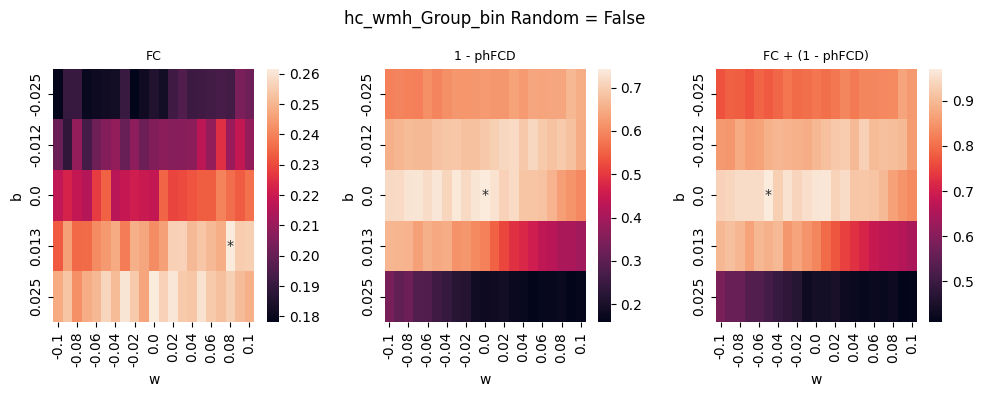

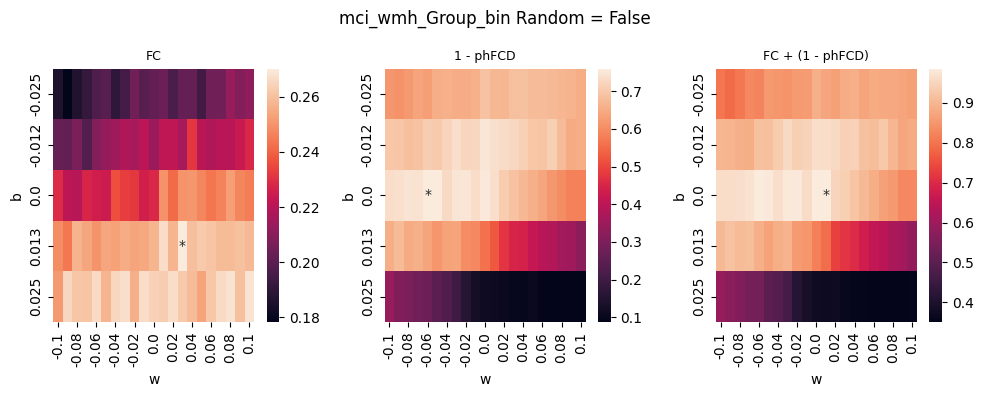

In [17]:
# Perform the analyses for different groups based on Fazekas classification
perform_group_analyses(adnimerge, df_a_big, "Group_Fazekas_1.0", random=False)
perform_group_analyses(adnimerge, df_a_big, "Group_Fazekas_2.0", random=False)
perform_group_analyses(adnimerge, df_a_big, "Group_bin", random=False)

In [34]:
# Select the best b and w for the Fazekas 1 and Fazekas 2 groupings
fzk1_best_fit_b_hc = 0.0
fzk1_best_fit_w_hc = -0.05
fzk1_best_fit_b_mci = 0.0
fzk1_best_fit_w_mci = -0.02

fzk2_best_fit_b_hc = -0.012
fzk2_best_fit_w_hc = 0.05
fzk2_best_fit_b_mci = 0.0
fzk2_best_fit_w_mci = -0.02

all_best_fit_b_hc = 0.0
all_best_fit_w_hc = -0.05
all_best_fit_b_mci = 0.0
all_best_fit_w_mci = 0.01

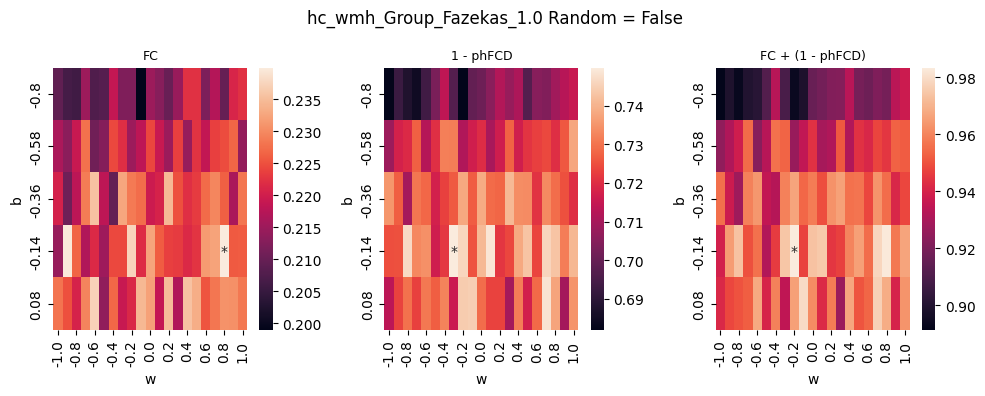

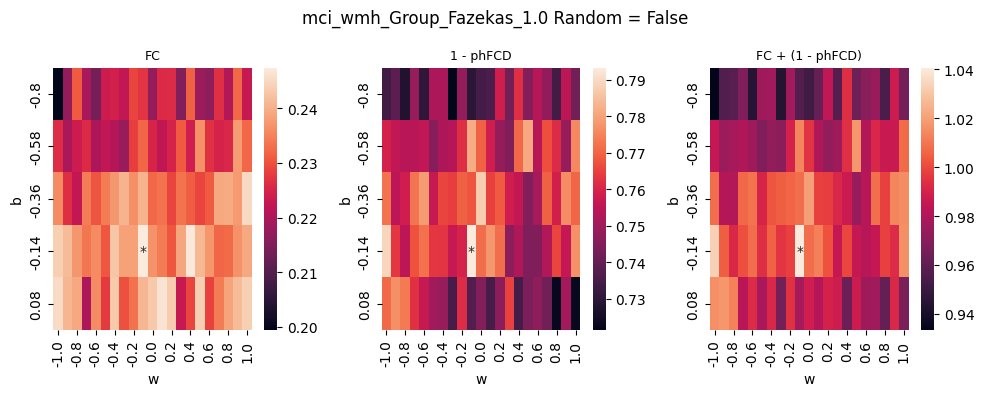

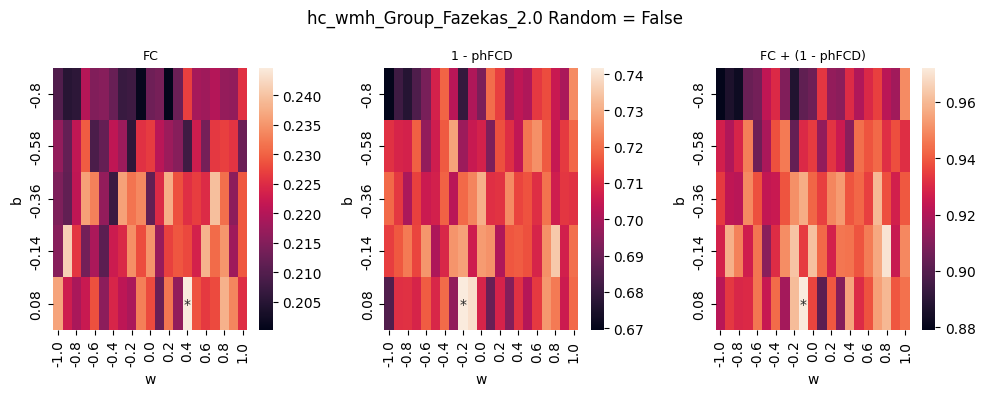

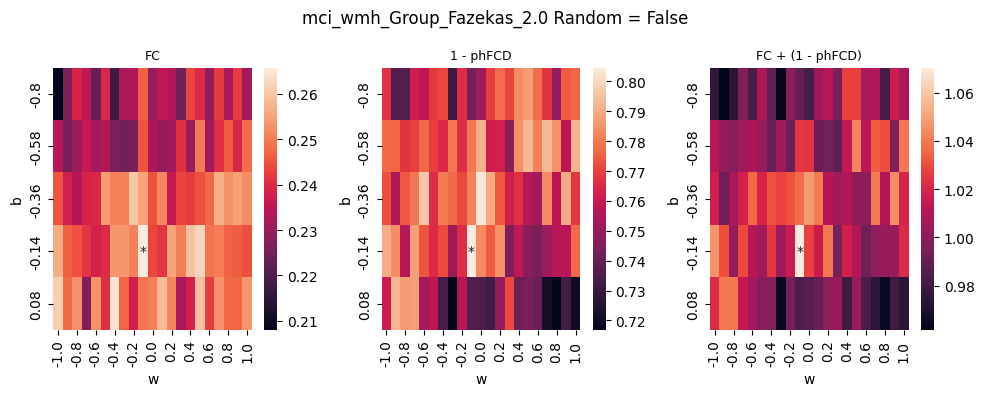

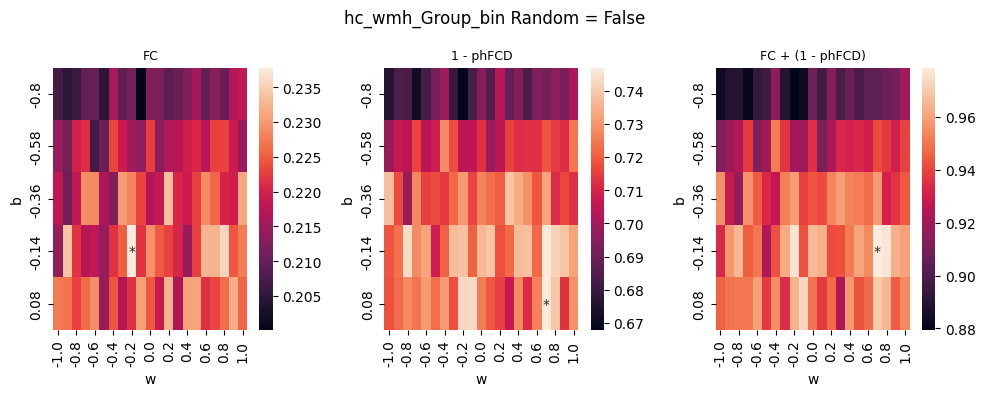

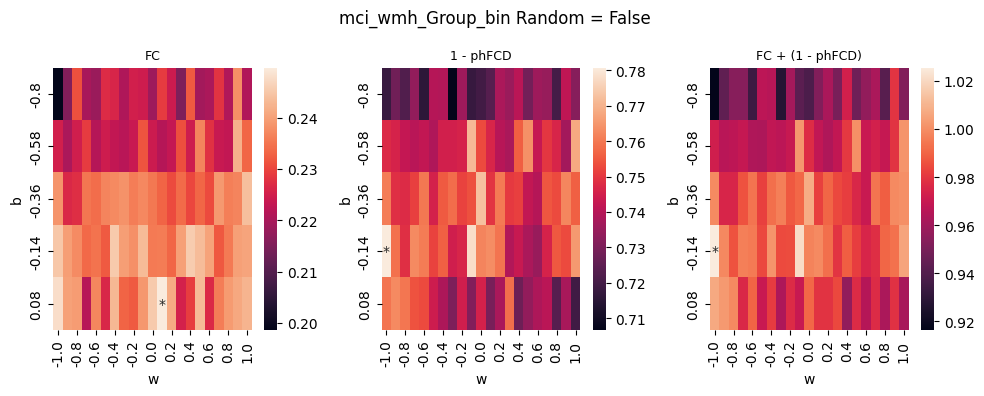

In [18]:
# Here we perform the same analyses, but for the homogeneous model where G was weighted based on the wmh load.
perform_group_analyses(adnimerge, df_G_big, "Group_Fazekas_1.0", random=False)
perform_group_analyses(adnimerge, df_G_big, "Group_Fazekas_2.0", random=False)
perform_group_analyses(adnimerge, df_G_big, "Group_bin", random=False)

In [19]:
# Select the best b and w for the Fazekas 1 and Fazekas 2 groupings
fzk1_best_fit_b_hc_G = -0.14
fzk1_best_fit_w_hc_G = -0.2
fzk1_best_fit_b_mci_G = -0.14
fzk1_best_fit_w_mci_G = -0.1

fzk2_best_fit_b_hc_G = 0.08
fzk2_best_fit_w_hc_G = -0.1
fzk2_best_fit_b_mci_G = -0.14
fzk2_best_fit_w_mci_G = -0.1

all_best_fit_b_hc_G = -0.14
all_best_fit_w_hc_G = 0.7
all_best_fit_b_mci_G = -0.14
all_best_fit_w_mci_G = -1.0

In [20]:
from statannotations.Annotator import Annotator

def plot_obs_compare_fzk1_fzk2_all(df, obs):
    # This is the order that also appears in the boxplot
    order = ["Fazekas 1", "Fazekas 2", "All"]
    # These are the possible couples for which we want to make the comparison
    pairs=[("Fazekas 1", "Fazekas 2"), ("Fazekas 1", "All"), ("Fazekas 2", "All")]
    # We plot the boxplot...
    ax = sns.boxplot(data = df, x = "Group", y = obs)
    # and we annotate it by choosing the best statistical test that we want.
    annotator = Annotator(ax, pairs, data=df, x="Group", y=obs, order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose = 0)
    annotator.apply_and_annotate()
    # We also give the proper names to the ticks of the boxplot
    plt.xticks([0, 1, 2], order)


def compare_fzk1_fzk2_all(df_big_boxplot,
                          fzk1_best_fit_b, 
                          fzk1_best_fit_w,
                          fzk2_best_fit_b,  
                          fzk2_best_fit_w,
                          all_best_fit_b, 
                          all_best_fit_w, 
                          diagnosis_group):
    """
    This function prepares the dataframes for each grouping and plots the comparison boxplot.
    """
    # Prepare boxplot of the FC values obtained with the best overall fits (b, w) previously found for Fazekas 1 and Fazekas 2 and all subjects of the group
    diagnosis_group_wmh = diagnosis_group + "_WMH"

    # Prepare dataframes for the different groupings (Fazekas 1, Fazekas 2, All HC/MCI)
    df_fzk1 = pd.DataFrame()
    df_fzk2 = pd.DataFrame()
    df_all = pd.DataFrame()

    # We create several df for the different groupings by choosing the fc and phfcd related to the best groupwise b and w from before
    df_fzk1["PTID"] = df_big_boxplot[(df_big_boxplot["b"] == fzk1_best_fit_b) & (df_big_boxplot["w"] == fzk1_best_fit_w) & (df_big_boxplot["Group_Fazekas_1.0"] == diagnosis_group_wmh)]["PTID"]
    df_fzk1["fc_pearson"] = df_big_boxplot[(df_big_boxplot["b"] == fzk1_best_fit_b) & (df_big_boxplot["w"] == fzk1_best_fit_w) & (df_big_boxplot["Group_Fazekas_1.0"] == diagnosis_group_wmh)]["fc_pearson"]
    df_fzk1["phfcd_ks"] = df_big_boxplot[(df_big_boxplot["b"] == fzk1_best_fit_b) & (df_big_boxplot["w"] == fzk1_best_fit_w) & (df_big_boxplot["Group_Fazekas_1.0"] == diagnosis_group_wmh)]["phfcd_ks"]
    df_fzk1["comp_score"] = df_fzk1["fc_pearson"] + df_fzk1["phfcd_ks"]
    df_fzk1["Group"] = ["Fazekas 1" for _ in range(len(df_fzk1))]

    df_fzk2["PTID"] = df_big_boxplot[(df_big_boxplot["b"] == fzk2_best_fit_b) & (df_big_boxplot["w"] == fzk2_best_fit_w) & (df_big_boxplot["Group_Fazekas_2.0"] == diagnosis_group_wmh)]["PTID"]
    df_fzk2["fc_pearson"] = df_big_boxplot[(df_big_boxplot["b"] == fzk2_best_fit_b) & (df_big_boxplot["w"] == fzk2_best_fit_w) & (df_big_boxplot["Group_Fazekas_2.0"] == diagnosis_group_wmh)]["fc_pearson"]
    df_fzk2["phfcd_ks"] = df_big_boxplot[(df_big_boxplot["b"] == fzk2_best_fit_b) & (df_big_boxplot["w"] == fzk2_best_fit_w) & (df_big_boxplot["Group_Fazekas_2.0"] == diagnosis_group_wmh)]["phfcd_ks"]
    df_fzk2["comp_score"] = df_fzk2["fc_pearson"] + df_fzk2["phfcd_ks"]
    df_fzk2["Group"] = ["Fazekas 2" for _ in range(len(df_fzk2))]

    df_all["PTID"] = df_big_boxplot[(df_big_boxplot["b"] == all_best_fit_b) & (df_big_boxplot["w"] == all_best_fit_w) & (df_big_boxplot["Group_bin"] == diagnosis_group)]["PTID"]
    df_all["fc_pearson"] = df_big_boxplot[(df_big_boxplot["b"] == all_best_fit_b) & (df_big_boxplot["w"] == all_best_fit_w) & (df_big_boxplot["Group_bin"] == diagnosis_group)]["fc_pearson"]
    df_all["phfcd_ks"] = df_big_boxplot[(df_big_boxplot["b"] == all_best_fit_b) & (df_big_boxplot["w"] == all_best_fit_w) & (df_big_boxplot["Group_bin"] == diagnosis_group)]["phfcd_ks"]
    df_all["comp_score"] = df_all["fc_pearson"] + df_all["phfcd_ks"]
    df_all["Group"] = ["All" for _ in range(len(df_all))]

    # Create a dataframe in long format to contain the data
    df = pd.concat([df_fzk1, df_fzk2, df_all])

    # Plot the boxplot
    fig = plt.figure(figsize = (12,4))
    plt.subplot(131)
    plot_obs_compare_fzk1_fzk2_all(df, "fc_pearson")
    plt.ylabel("FC")
    plt.subplot(132)
    plot_obs_compare_fzk1_fzk2_all(df, "phfcd_ks")
    plt.ylabel("1 - phFCD")
    plt.subplot(133)
    plot_obs_compare_fzk1_fzk2_all(df, "comp_score")
    plt.ylabel("FC + (1 - phFCD)")
    fig.text(0, -0.1, "Note: For the category 'Fazekas 1' and 'Fazekas 2' we include only patients classified as WMH\nFor the category 'All' we include patients both with and without WMH")
    fig.suptitle(diagnosis_group)
    fig.tight_layout()

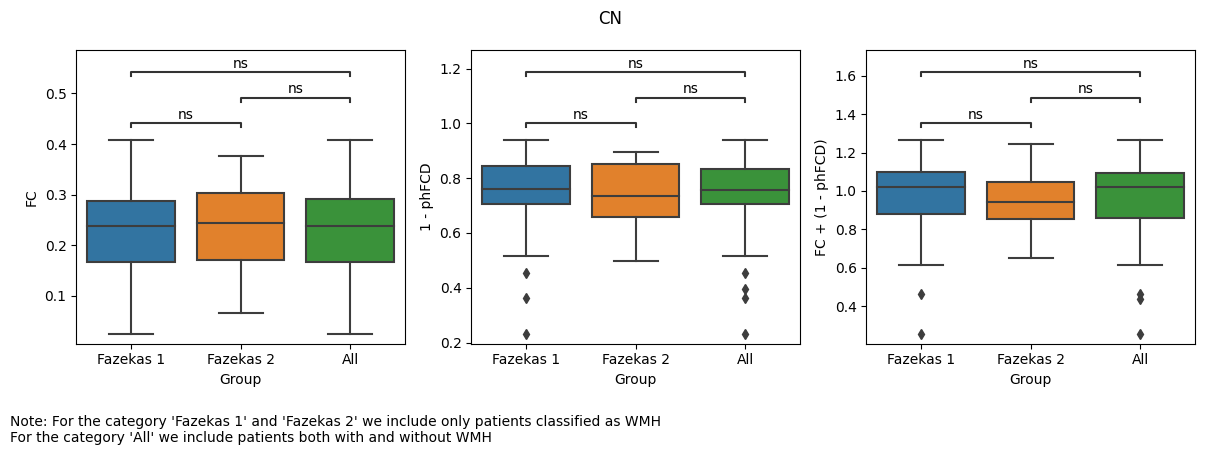

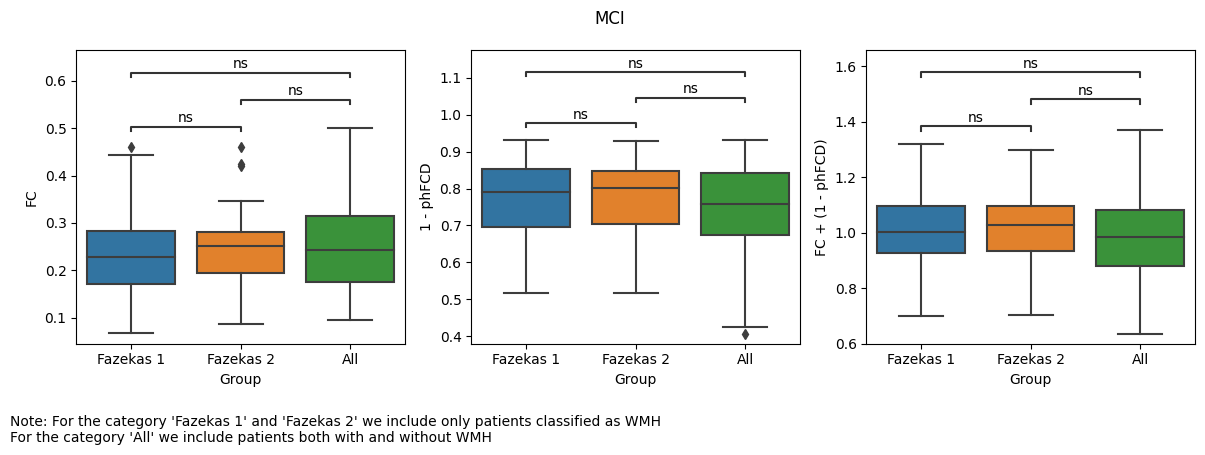

In [23]:
# We perform the comparison for the homogenous model where a was weighted based on the normalized wmh load for both HC and MCI
df_a_big_boxplot = pd.merge(
    df_a_big, adnimerge[["PTID", "Group_Fazekas_2.0", "Group_Fazekas_1.0", "Group_bin"]], on="PTID"
)
compare_fzk1_fzk2_all(df_a_big_boxplot,
                          fzk1_best_fit_b_hc, 
                          fzk1_best_fit_w_hc,
                          fzk2_best_fit_b_hc,  
                          fzk2_best_fit_w_hc,
                          all_best_fit_b_hc, 
                          all_best_fit_w_hc, 
                          "CN")
compare_fzk1_fzk2_all(df_a_big_boxplot,
                          fzk1_best_fit_b_mci, 
                          fzk1_best_fit_w_mci,
                          fzk2_best_fit_b_mci,  
                          fzk2_best_fit_w_mci,
                          all_best_fit_b_mci, 
                          all_best_fit_w_mci, 
                          "MCI")                                     

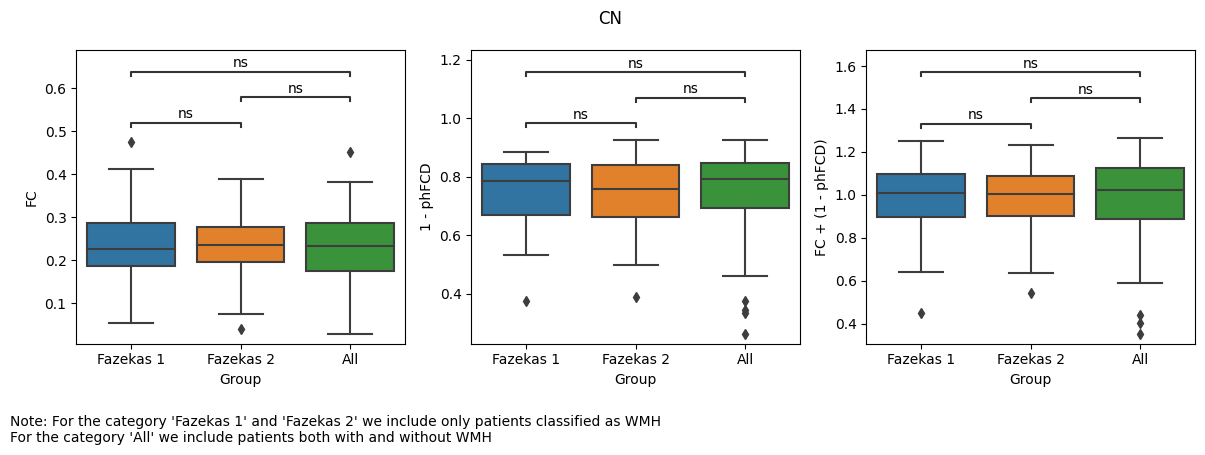

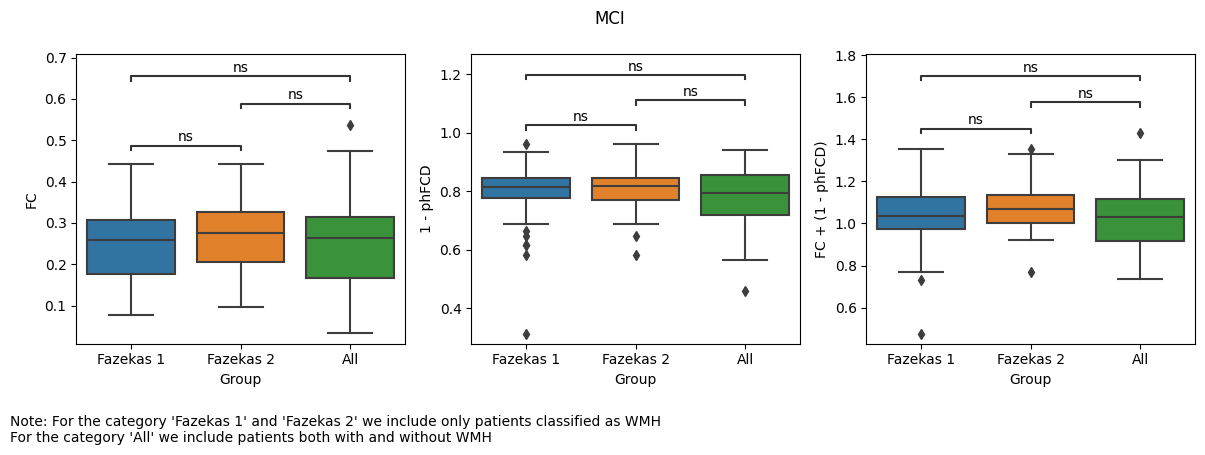

In [24]:
# We perform the comparison for the homogenous model where G was weighted based on the normalized wmh load for both HC and MCI
df_G_big_boxplot = pd.merge(
    df_G_big, adnimerge[["PTID", "Group_Fazekas_2.0", "Group_Fazekas_1.0", "Group_bin"]], on="PTID"
)
compare_fzk1_fzk2_all(df_G_big_boxplot,
                          fzk1_best_fit_b_hc_G, 
                          fzk1_best_fit_w_hc_G,
                          fzk2_best_fit_b_hc_G,  
                          fzk2_best_fit_w_hc_G,
                          all_best_fit_b_hc_G, 
                          all_best_fit_w_hc_G, 
                          "CN")
compare_fzk1_fzk2_all(df_G_big_boxplot,
                          fzk1_best_fit_b_mci_G, 
                          fzk1_best_fit_w_mci_G,
                          fzk2_best_fit_b_mci_G,  
                          fzk2_best_fit_w_mci_G,
                          all_best_fit_b_mci_G, 
                          all_best_fit_w_mci_G, 
                          "MCI")
                                    

Using a Fazekas cutoff of <= 1 or <= 2 or not using any cutoff based on WMH doesn't really change how better fits we achieve for the homogeneous model nor for the model where we weight G based on WMH load.

### Model analyses

Since there seem to be no real difference between the groups, we just use a threshold of Fazekas = 2 as it is clinically more sound. Remember to check how you want to calculate the composite score!

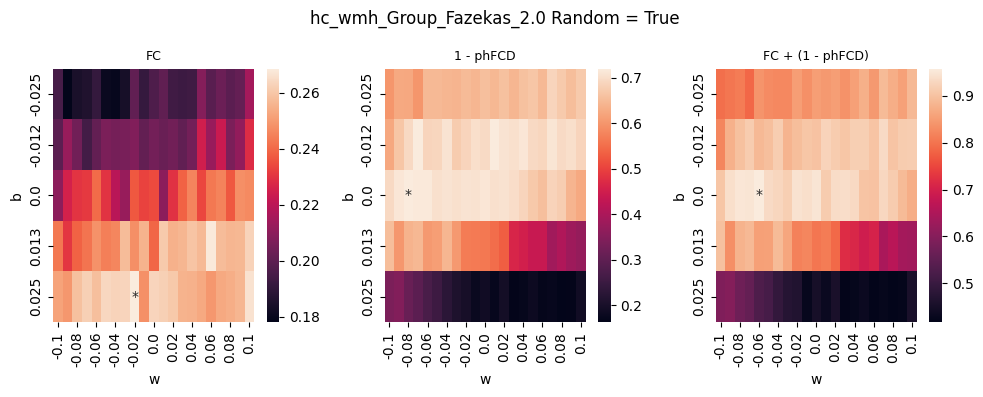

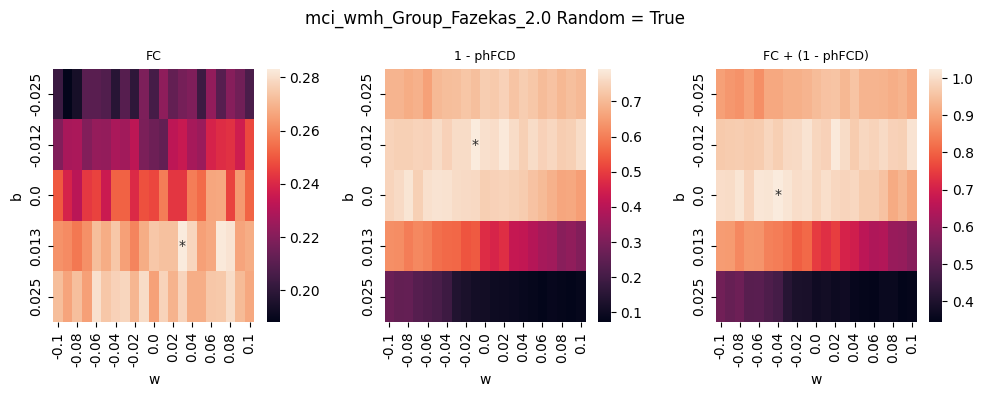

In [25]:
# Perform the group-level analyses for the homogeneous random group where a was weighted by wmh loads, but randomly shuffled beforehand
perform_group_analyses(adnimerge, df_a_rand_big, "Group_Fazekas_2.0", random=True)

In [33]:
best_fit_b_hc_a_rand = 0.0
best_fit_w_hc_a_rand = -0.06
best_fit_b_mci_a_rand = 0.0
best_fit_w_mci_a_rand = -0.04

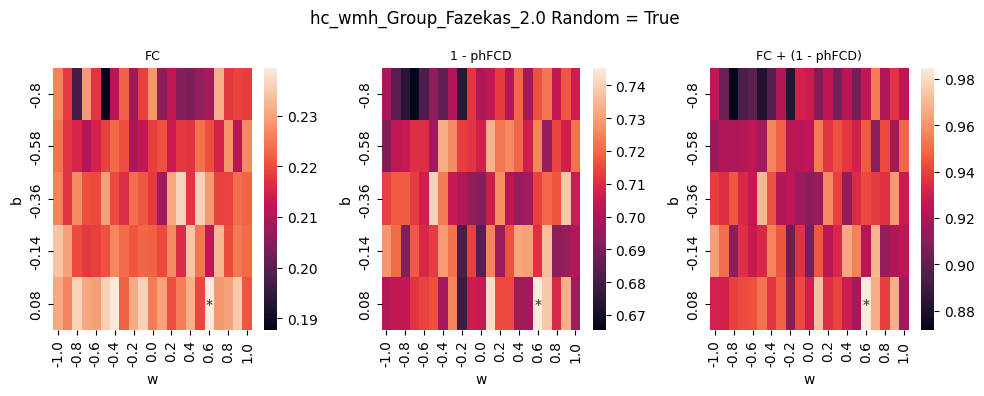

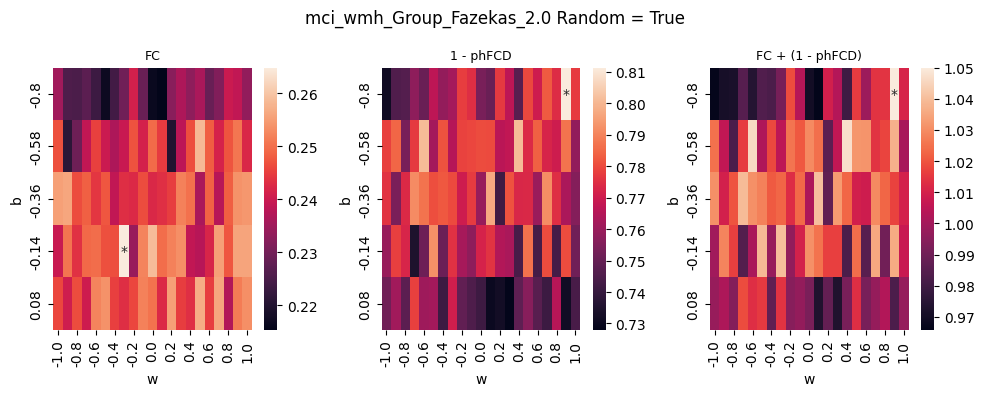

In [27]:
perform_group_analyses(adnimerge, df_G_rand_big, "Group_Fazekas_2.0", random=True)

In [28]:
best_fit_b_hc_G_rand = 0.08
best_fit_w_hc_G_rand = 0.6
best_fit_b_mci_G_rand = -0.8
best_fit_w_mci_G_rand = 0.9

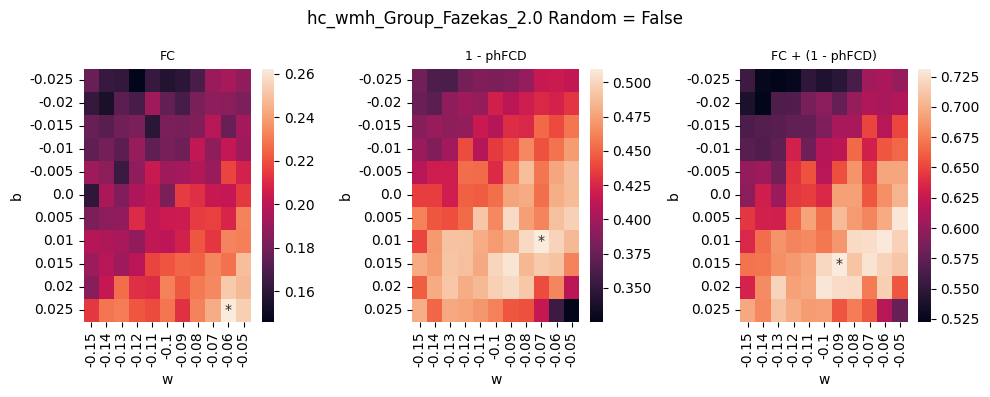

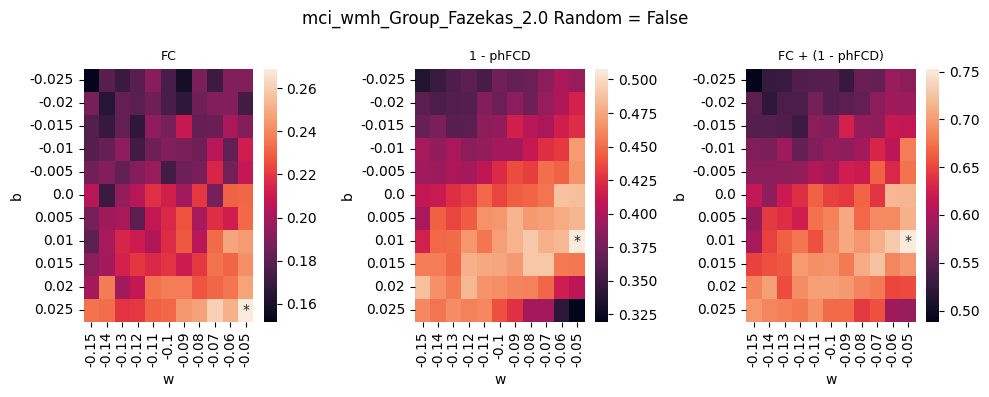

In [29]:
# Perform the group level analyses for the heterogeneous model
df_het_big["w"] = (
    df_het_big["w"] * -1
)  # I performed the simulation with a - and positive weights (so just invert to be the same as the other simulations)
perform_group_analyses(adnimerge, df_het_big, "Group_Fazekas_2.0", False)

In [30]:
best_fit_b_hc_het = 0.015
best_fit_w_hc_het = -0.09
best_fit_b_mci_het = 0.01
best_fit_w_mci_het = -0.05

In [50]:
def create_df_boxplot(df_big,
                      best_fit_b,
                      best_fit_w,
                      diagnosis_group_wmh,
                      model_type):

    """
    This function starts from the big database obtained from the model simulation (e.g., a-weighted homogenous, G-weighted homgoeneous, heterogeneous, etc.) and creates
    a smaller dataset with only the observable variables obtained with the best b and w combination as before. It is useful to then create a long df for plotting.
    """
    df = pd.DataFrame()
    df["PTID"] = df_big[(df_big["b"] == best_fit_b) & (df_big["w"] == best_fit_w) & (df_big["Group_Fazekas_2.0"] == diagnosis_group_wmh)]["PTID"]
    df["fc_pearson"] = df_big[(df_big["b"] == best_fit_b) & (df_big["w"] == best_fit_w) & (df_big["Group_Fazekas_2.0"] == diagnosis_group_wmh)]["fc_pearson"]
    df["phfcd_ks"] = df_big[(df_big["b"] == best_fit_b) & (df_big["w"] == best_fit_w) & (df_big["Group_Fazekas_2.0"] == diagnosis_group_wmh)]["phfcd_ks"]
    df["comp_score"] = df["fc_pearson"] + 2*df["phfcd_ks"]
    df["Model_type"] = [f"{model_type}" for _ in range(len(df))]
    return df

# Since we are using only Fazekas 2 change the name for consistency
best_fit_b_hc_a, best_fit_w_hc_a = fzk2_best_fit_b_hc, fzk2_best_fit_w_hc 
best_fit_b_hc_G, best_fit_w_hc_G = fzk2_best_fit_b_hc_G, fzk2_best_fit_w_hc_G

# Already merged df: df_a_big_boxplot, df_G_big_boxplot
# We create merged databases with clinical information for the remaining models
df_a_rand_big_boxplot = pd.merge(
    df_a_rand_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_het_big_boxplot = pd.merge(
    df_het_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_G_rand_big_boxplot = pd.merge(
    df_G_rand_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

df_sc_big_boxplot = pd.merge(
    df_sc_big, adnimerge[["PTID", "Group_Fazekas_2.0"]], on="PTID"
)

# Create df with only the best values from before for HC
df_boxplot_compare_hc_base = create_df_boxplot(df_a_big_boxplot, 0, 0, "CN_WMH", "Base")
df_boxplot_compare_hc_a = create_df_boxplot(df_a_big_boxplot, best_fit_b_hc_a, best_fit_w_hc_a, "CN_WMH", "Homo.")
df_boxplot_compare_hc_a_rand = create_df_boxplot(df_a_rand_big_boxplot, best_fit_b_hc_a_rand, best_fit_w_hc_a_rand, "CN_WMH", "Homo. rand.")

# Currently there are some patients with na in the heterogeneous model.. we drop them for the moment 
df_boxplot_compare_hc_het = create_df_boxplot(df_het_big_boxplot, best_fit_b_hc_het, best_fit_w_hc_het, "CN_WMH", "Hetero.")
df_boxplot_compare_hc_het = df_boxplot_compare_hc_het.dropna()

df_boxplot_compare_hc_G = create_df_boxplot(df_G_big_boxplot, best_fit_b_hc_G, best_fit_w_hc_G, "CN_WMH", "G-weight")
df_boxplot_compare_hc_G_rand = create_df_boxplot(df_G_rand_big_boxplot, best_fit_b_hc_G_rand, best_fit_w_hc_G_rand, "CN_WMH", "G rand.")

df_boxplot_compare_hc_sc = df_sc_big_boxplot[df_sc_big_boxplot["Group_Fazekas_2.0"] == "CN_WMH"].drop(columns = "Group_Fazekas_2.0")
# The structural disconnectivity model doesn't have a weight, so its processing is slightly different
df_boxplot_compare_hc_sc["comp_score"] = df_boxplot_compare_hc_sc["fc_pearson"] + 2*df_boxplot_compare_hc_sc["phfcd_ks"]
df_boxplot_compare_hc_sc["Model_type"] = "Disconn."

df_boxplot_compare_hc = pd.concat([df_boxplot_compare_hc_base, df_boxplot_compare_hc_a, df_boxplot_compare_hc_a_rand, df_boxplot_compare_hc_het, df_boxplot_compare_hc_G, df_boxplot_compare_hc_G_rand, df_boxplot_compare_hc_sc])

Text(0, -0.05, 'Note: Some patients in the heterogeneous model have Nans! They were dropped out for the moment')

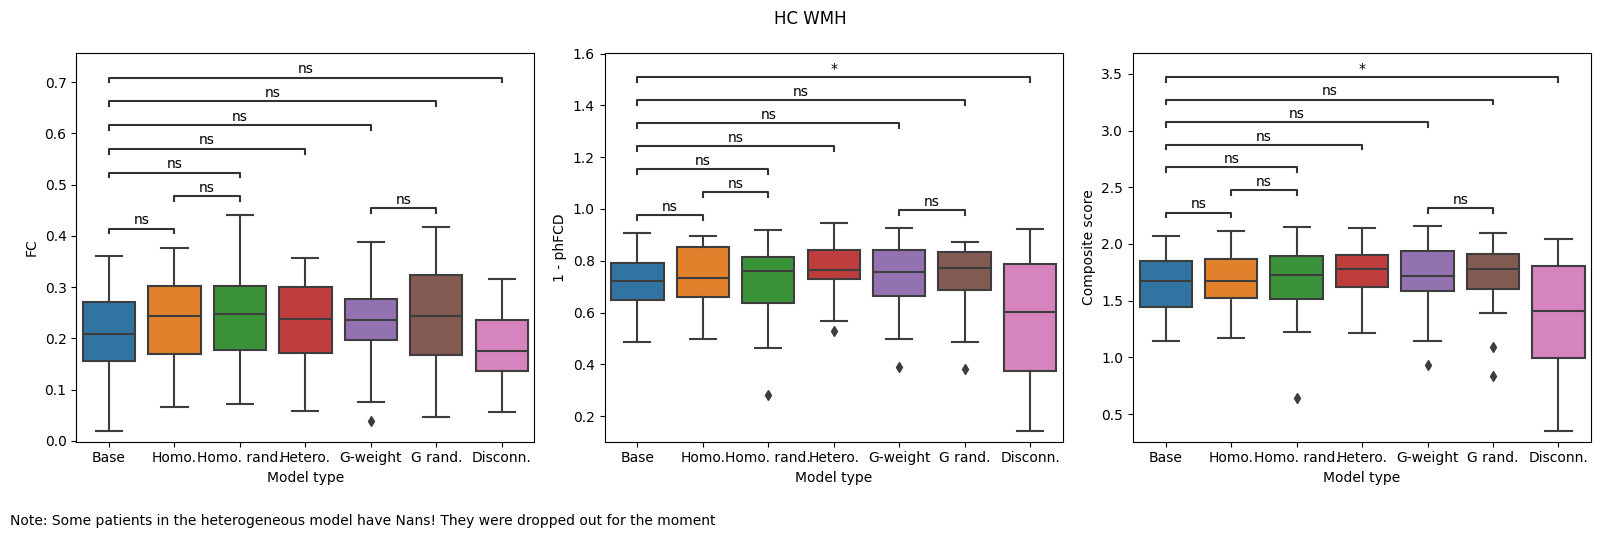

In [55]:
def plot_obs(df, obs):
    """
    This function plots the annotations for statistical comparisons between groups
    """
    order = ["Base", "Homo.", "Homo. rand.", "Hetero.", "G-weight", "G rand.", "Disconn."]
    # Choose the combinations that you want to test..
    pairs=[("Base", "Homo."),
           ("Base", "Homo. rand."),
           ("Base", "Hetero."),
           ("Base", "G-weight"),
           ("Base", "G rand."),
           ("Base", "Disconn."),
           ("Homo.", "Homo. rand."),
           ("G-weight", "G rand.")]
    ax = sns.boxplot(data = df, x = "Model_type", y = obs)
    annotator = Annotator(ax, pairs, data=df, x="Model_type", y=obs, order=order)
    # Choose the type of statistical test to perform
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose = 0)
    annotator.apply_and_annotate()
    plt.xticks([0, 1, 2, 3, 4, 5, 6], order)
    plt.xlabel("Model type")

# Plot the boxplot
fig = plt.figure(figsize = (16, 5))
plt.subplot(131)
plot_obs(df_boxplot_compare_hc, "fc_pearson")
plt.ylabel("FC")
plt.subplot(132)
plot_obs(df_boxplot_compare_hc, "phfcd_ks")
plt.ylabel("1 - phFCD")
plt.subplot(133)
plot_obs(df_boxplot_compare_hc, "comp_score")
plt.ylabel("Composite score")
fig.suptitle("HC WMH")
fig.tight_layout()
fig.text(0, -0.05, "Note: Some patients in the heterogeneous model have Nans! They were dropped out for the moment")

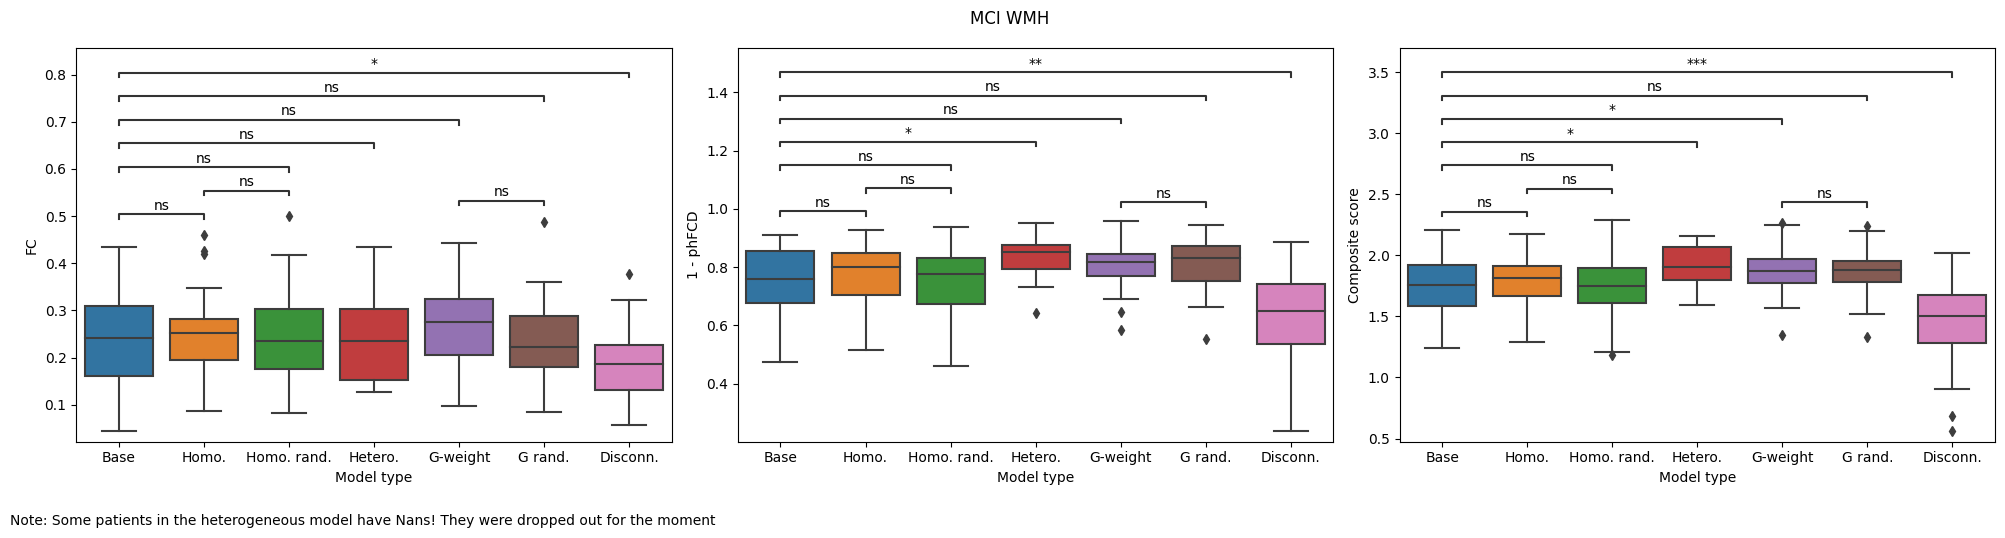

In [68]:
# Since we are using only Fazekas 2 change the name for consistency
best_fit_b_mci_a, best_fit_w_mci_a = fzk2_best_fit_b_mci, fzk2_best_fit_w_mci 
best_fit_b_mci_G, best_fit_w_mci_G = fzk2_best_fit_b_mci_G, fzk2_best_fit_w_mci_G
# Perform the same steps done with HC but on MCI
# Create df with only the best values from before for MCI
df_boxplot_compare_mci_base = create_df_boxplot(df_a_big_boxplot, 0, 0, "MCI_WMH", "Base")
df_boxplot_compare_mci_a = create_df_boxplot(df_a_big_boxplot, best_fit_b_mci_a, best_fit_w_mci_a, "MCI_WMH", "Homo.")
df_boxplot_compare_mci_a_rand = create_df_boxplot(df_a_big_boxplot, best_fit_b_mci_a_rand, best_fit_w_mci_a_rand, "MCI_WMH", "Homo. rand.")
df_boxplot_compare_mci_het = create_df_boxplot(df_het_big_boxplot, best_fit_b_mci_het, best_fit_w_mci_het, "MCI_WMH", "Hetero.")
df_boxplot_compare_mci_het = df_boxplot_compare_mci_het.dropna()
df_boxplot_compare_mci_G = create_df_boxplot(df_G_big_boxplot, best_fit_b_mci_G, best_fit_w_mci_G, "MCI_WMH", "G-weight")
df_boxplot_compare_mci_G_rand = create_df_boxplot(df_G_rand_big_boxplot, best_fit_b_mci_G_rand, best_fit_w_mci_G_rand, "MCI_WMH", "G rand.")
df_boxplot_compare_mci_sc = df_sc_big_boxplot[df_sc_big_boxplot["Group_Fazekas_2.0"] == "MCI_WMH"].drop(columns = "Group_Fazekas_2.0")
df_boxplot_compare_mci_sc["comp_score"] = df_boxplot_compare_mci_sc["fc_pearson"] + 2*df_boxplot_compare_mci_sc["phfcd_ks"]
df_boxplot_compare_mci_sc["Model_type"] = "Disconn."
df_boxplot_compare_mci = pd.concat([df_boxplot_compare_mci_base, df_boxplot_compare_mci_a, df_boxplot_compare_mci_a_rand, df_boxplot_compare_mci_het, df_boxplot_compare_mci_G, df_boxplot_compare_mci_G_rand, df_boxplot_compare_mci_sc])
# Plot the boxplot
fig = plt.figure(figsize = (20, 5))
plt.subplot(131)
plot_obs(df_boxplot_compare_mci, "fc_pearson")
plt.ylabel("FC")
plt.subplot(132)
plot_obs(df_boxplot_compare_mci, "phfcd_ks")
plt.ylabel("1 - phFCD")
plt.subplot(133)
plot_obs(df_boxplot_compare_mci, "comp_score")
plt.ylabel("Composite score")
fig.suptitle("MCI WMH")
fig.text(0, -0.05, "Note: Some patients in the heterogeneous model have Nans! They were dropped out for the moment")
fig.tight_layout()

In [69]:
def plot_hc_mci_comparison(obs, axs):
    """
    This function is for plotting the comparison between the model results achieved in HC and MCI with the same model"""
    pairs = [
        (("Base", "CN WMH"), ("Base", "MCI WMH")),
        (("Homo.", "CN WMH"), ("Homo.", "MCI WMH")),
        (("Homo. rand.", "CN WMH"), ("Homo. rand.", "MCI WMH")),
        (("Hetero.", "CN WMH"), ("Hetero.", "MCI WMH")),
        (("G-weight", "CN WMH"), ("G-weight", "MCI WMH")),
        (("G rand.", "CN WMH"), ("G rand.", "MCI WMH")),
        (("Disconn.", "CN WMH"), ("Disconn.", "MCI WMH")),
    ]

    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        'plot_params': { # this takes what normally goes into sns.barplot etc.
            'x': 'Model_type',
            'y': f'{obs}',
            'hue': 'group',
            'hue_order': ["CN WMH","MCI WMH"]
        },
        'annotation_func': 'apply_test', 
        'configuration': {'test': 'Mann-Whitney'}, # this takes what normally goes into ant.configure
        'plot': 'boxplot',
        # If you want to add the figure into a subplot...
        'ax': axs
    }

    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df_boxplot_compare, aspect = 1.5, height = 4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which 
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    plt.close()

# sns.despine(offset=10, trim=True)
# Create a unified long df to compare the model performance between groups
df_boxplot_compare_hc["group"] = "CN WMH"
df_boxplot_compare_mci["group"] = "MCI WMH"
df_boxplot_compare = pd.concat([df_boxplot_compare_hc, df_boxplot_compare_mci])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Homo._CN WMH vs. Homo._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:7.062e-01 U_stat=4.240e+02
Base_CN WMH vs. Base_MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:2.282e-01 U_stat=3.680e+02
Homo. rand._CN WMH vs. Homo. rand._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:9.587e-01 U_stat=4.460e+02
Hetero._CN WMH vs. Hetero._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:9.153e-01 U_stat=1.670e+02
G-weight_CN WMH vs. G-weight_MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:1.260e-01 U_stat=3.460e+02
G rand._CN WMH vs. G rand._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:9.234e-01 U_stat=4.570e+02
Disconn._CN WMH vs. Disconn._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:9.117e-01 U_stat=4.580e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-0

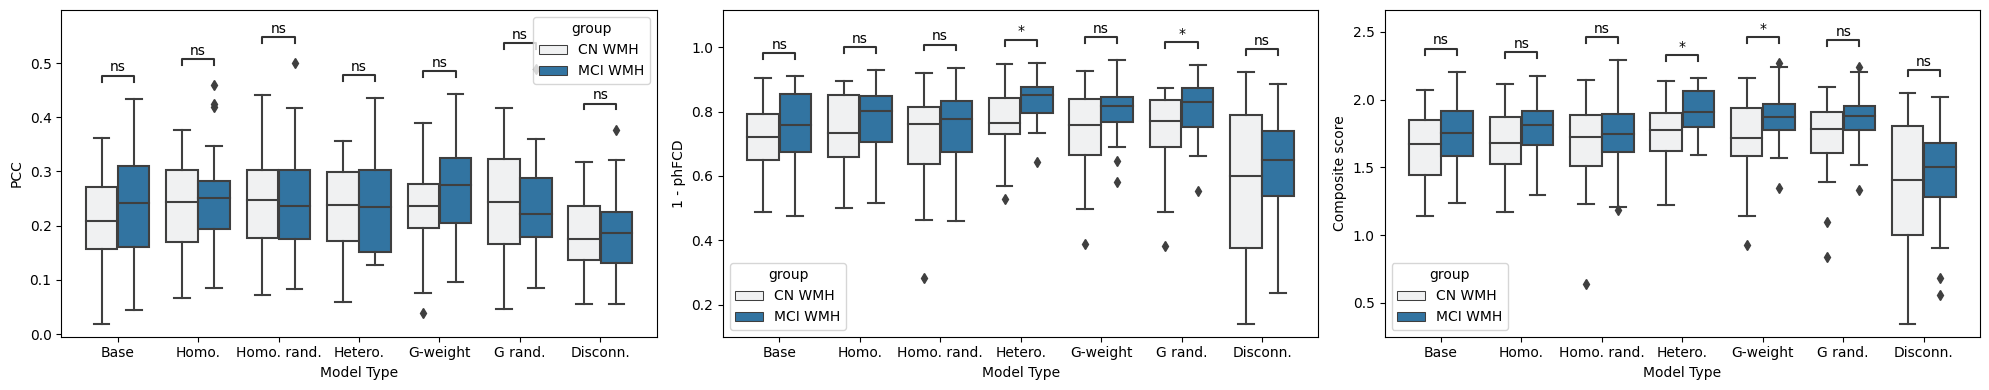

In [70]:
# Plot the model performance between groups
fig, axs = plt.subplots(nrows= 1, ncols = 3, figsize = (20, 4))
plot_hc_mci_comparison('fc_pearson', axs[0])
axs[0].set_ylabel("PCC")
axs[0].set_xlabel("Model Type")
plot_hc_mci_comparison('phfcd_ks', axs[1])
axs[1].set_ylabel("1 - phFCD")
axs[1].set_xlabel("Model Type")
plot_hc_mci_comparison('comp_score', axs[2])
axs[2].set_ylabel("Composite score")
axs[2].set_xlabel("Model Type")
fig.tight_layout()

In [95]:
# Now let's plot the best FC and 1-phFCDs achievable in the range of explored parameters 
df_base_merged = pd.merge(df_base, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_a_merged = pd.merge(df_max_fc_a, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_a_rand_merged = pd.merge(df_max_fc_a_rand, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_hetero_merged = pd.merge(df_max_fc_hetero, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_G_merged = pd.merge(df_max_fc_G, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_G_rand_merged = pd.merge(df_max_fc_G_rand, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_fc_sc_merged = pd.merge(df_max_fc_sc, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")

df_base_merged["Model_type"] = "Base"

df_max_fc_a_merged["Model_type"] = "Homo."
df_max_fc_a_rand_merged["Model_type"] = "Homo. rand."
df_max_fc_hetero_merged["Model_type"] = "Hetero."
df_max_fc_G_merged["Model_type"] = "G-weight"
df_max_fc_G_rand_merged["Model_type"] = "G rand."
df_max_fc_sc_merged["Model_type"] = "Disconn."

df_max_phfcd_a_merged = pd.merge(df_max_phfcd_a, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_phfcd_a_rand_merged = pd.merge(df_max_phfcd_a_rand, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_phfcd_sc_merged = pd.merge(df_max_phfcd_sc, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_phfcd_G_merged = pd.merge(df_max_phfcd_G, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_phfcd_G_rand_merged = pd.merge(df_max_phfcd_G_rand, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")
df_max_phfcd_hetero_merged = pd.merge(df_max_phfcd_hetero, adnimerge[["PTID", "Group_Fazekas_2.0"]], on = "PTID")

df_max_phfcd_a_merged["Model_type"] = "Homo."
df_max_phfcd_a_rand_merged["Model_type"] = "Homo. rand."
df_max_phfcd_hetero_merged["Model_type"] = "Hetero."
df_max_phfcd_G_merged["Model_type"] = "G-weight"
df_max_phfcd_G_rand_merged["Model_type"] = "G rand."
df_max_phfcd_sc_merged["Model_type"] = "Disconn."

In [96]:
# Select only HC
df_base_merged_hc = df_base_merged[df_base_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_a_merged_hc = df_max_fc_a_merged[df_max_fc_a_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_a_rand_merged_hc = df_max_fc_a_rand_merged[df_max_fc_a_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_hetero_merged_hc = df_max_fc_hetero_merged[df_max_fc_hetero_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_G_merged_hc = df_max_fc_G_merged[df_max_fc_G_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_G_rand_merged_hc = df_max_fc_G_rand_merged[df_max_fc_G_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_fc_sc_merged_hc = df_max_fc_sc_merged[df_max_fc_sc_merged["Group_Fazekas_2.0"] == "CN_WMH"]

df_max_phfcd_a_merged_hc = df_max_phfcd_a_merged[df_max_phfcd_a_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_phfcd_a_rand_merged_hc = df_max_phfcd_a_rand_merged[df_max_phfcd_a_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_phfcd_hetero_merged_hc = df_max_phfcd_hetero_merged[df_max_phfcd_hetero_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_phfcd_hetero_merged_hc = df_max_phfcd_hetero_merged_hc.dropna()
df_max_phfcd_G_merged_hc = df_max_phfcd_G_merged[df_max_phfcd_G_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_phfcd_G_rand_merged_hc = df_max_phfcd_G_rand_merged[df_max_phfcd_G_rand_merged["Group_Fazekas_2.0"] == "CN_WMH"]
df_max_phfcd_sc_merged_hc = df_max_phfcd_sc_merged[df_max_phfcd_sc_merged["Group_Fazekas_2.0"] == "CN_WMH"]

df_max_fc_hc = pd.concat([df_base_merged_hc, df_max_fc_a_merged_hc, df_max_fc_a_rand_merged_hc, df_max_fc_hetero_merged_hc, df_max_fc_G_merged_hc, df_max_fc_G_rand_merged_hc, df_max_fc_sc_merged_hc])
df_max_phfcd_hc = pd.concat([df_base_merged_hc, df_max_phfcd_a_merged_hc, df_max_phfcd_a_rand_merged_hc, df_max_phfcd_hetero_merged_hc, df_max_phfcd_G_merged_hc, df_max_phfcd_G_rand_merged_hc, df_max_phfcd_sc_merged_hc])

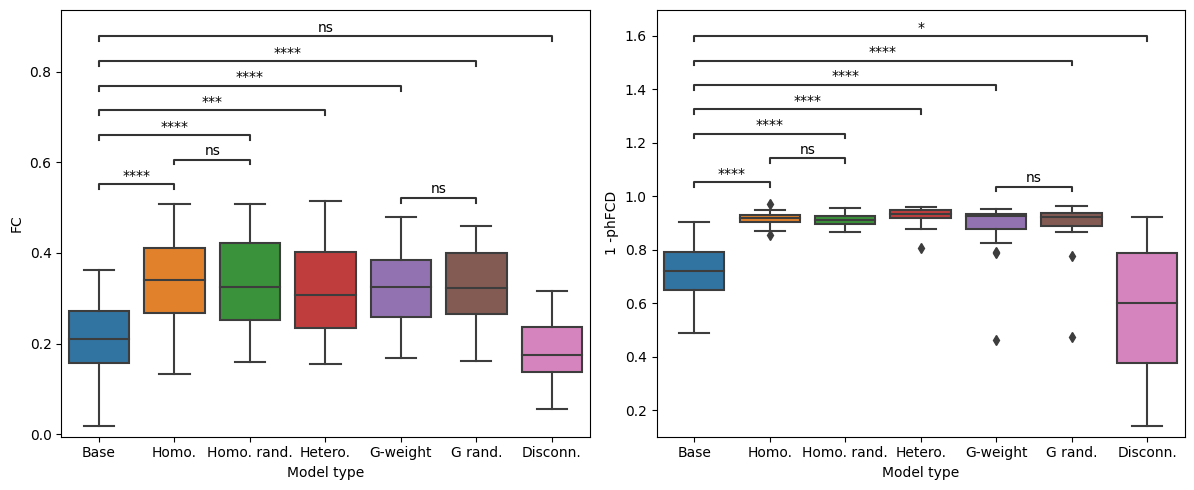

In [101]:
# It doesn't make sense to create a composite score, because we have that the value that gives the best FC is not the same that gives the best phFCD...
# Plot the boxplot
fig = plt.figure(figsize = (18, 5))
plt.subplot(131)
plot_obs(df_max_fc_hc, "fc_pearson")
plt.ylabel("FC")
plt.subplot(132)
plot_obs(df_max_phfcd_hc, "phfcd_ks")
plt.ylabel("1 -phFCD")
fig.tight_layout()

In [98]:
# Select only MCI
df_base_merged_mci = df_base_merged[df_base_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_a_merged_mci = df_max_fc_a_merged[df_max_fc_a_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_a_rand_merged_mci = df_max_fc_a_rand_merged[df_max_fc_a_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_hetero_merged_mci = df_max_fc_hetero_merged[df_max_fc_hetero_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_G_merged_mci = df_max_fc_G_merged[df_max_fc_G_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_G_rand_merged_mci = df_max_fc_G_rand_merged[df_max_fc_G_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_fc_sc_merged_mci = df_max_fc_sc_merged[df_max_fc_sc_merged["Group_Fazekas_2.0"] == "MCI_WMH"]

df_max_phfcd_a_merged_mci = df_max_phfcd_a_merged[df_max_phfcd_a_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_phfcd_a_rand_merged_mci = df_max_phfcd_a_rand_merged[df_max_phfcd_a_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_phfcd_hetero_merged_mci = df_max_phfcd_hetero_merged[df_max_phfcd_hetero_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_phfcd_hetero_merged_mci = df_max_phfcd_hetero_merged_mci.dropna()
df_max_phfcd_G_merged_mci = df_max_phfcd_G_merged[df_max_phfcd_G_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_phfcd_G_rand_merged_mci = df_max_phfcd_G_rand_merged[df_max_phfcd_G_rand_merged["Group_Fazekas_2.0"] == "MCI_WMH"]
df_max_phfcd_sc_merged_mci = df_max_phfcd_sc_merged[df_max_phfcd_sc_merged["Group_Fazekas_2.0"] == "MCI_WMH"]

df_max_fc_mci = pd.concat([df_base_merged_mci, df_max_fc_a_merged_mci, df_max_fc_a_rand_merged_mci, df_max_fc_hetero_merged_mci, df_max_fc_G_merged_mci, df_max_fc_G_rand_merged_mci, df_max_fc_sc_merged_mci])
df_max_phfcd_mci = pd.concat([df_base_merged_mci, df_max_phfcd_a_merged_mci, df_max_phfcd_a_rand_merged_mci, df_max_phfcd_hetero_merged_mci, df_max_phfcd_G_merged_mci, df_max_fc_G_rand_merged_mci, df_max_phfcd_sc_merged_mci])

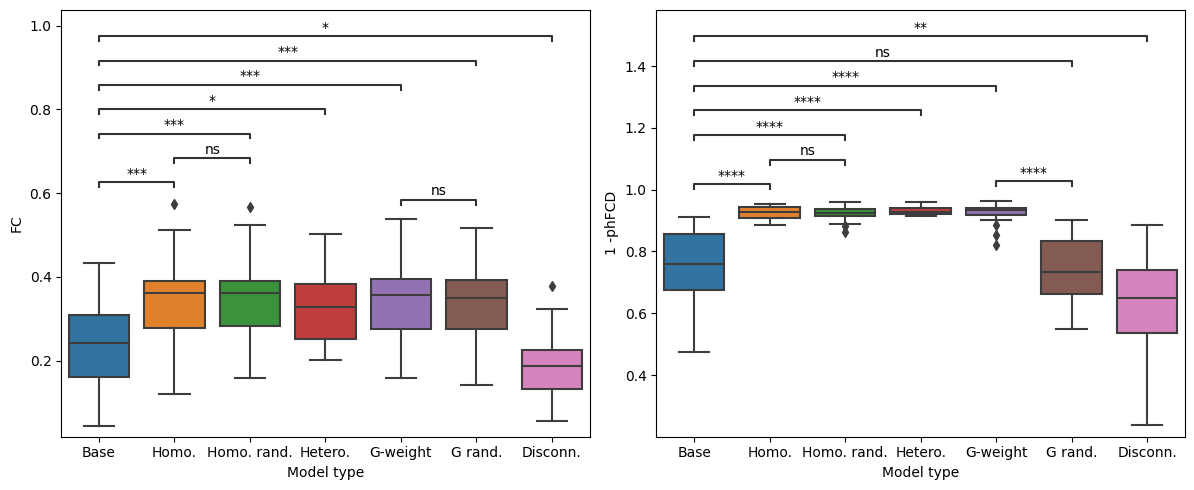

In [100]:
# It doesn't make sense to create a composite score, because we have that the value that gives the best FC is not the same that gives the best phFCD...
# Plot the boxplot
fig = plt.figure(figsize = (18, 5))
plt.subplot(131)
plot_obs(df_max_fc_mci, "fc_pearson")
plt.ylabel("FC")
plt.subplot(132)
plot_obs(df_max_phfcd_mci, "phfcd_ks")
plt.ylabel("1 -phFCD")
fig.tight_layout()

C:\Users\leoner\AppData\Local\Temp\ipykernel_12812\1434920854.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_subj["a"] = -0.02 + bad_subj["w"] * bad_subj["wmh_load"] + bad_subj["b"]
C:\Users\leoner\AppData\Local\Temp\ipykernel_12812\1434920854.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_subj["a"] = -0.02 + good_subj["w"] * good_subj["wmh_load"] + good_subj["b"]


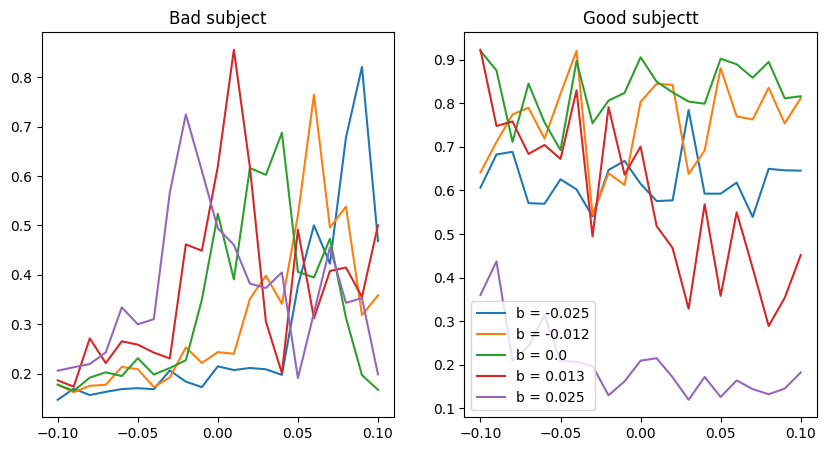

In [102]:
bad_hc = df_boxplot_compare_hc[df_boxplot_compare_hc["phfcd_ks"] < 0.6].groupby("PTID").count()
very_bad_hc = bad_hc[bad_hc["fc_pearson"] > 3]
bad_mci = df_boxplot_compare_mci[df_boxplot_compare_mci["phfcd_ks"] < 0.6].groupby("PTID").count()
very_bad_mci = bad_mci[bad_mci["fc_pearson"] > 3]
bad_subj = df_a_big[
    df_a_big["PTID"]
    == df_boxplot_compare_hc[df_boxplot_compare_hc["phfcd_ks"] < 0.4]["PTID"].unique()[0]
]
bad_subj["a"] = -0.02 + bad_subj["w"] * bad_subj["wmh_load"] + bad_subj["b"]

good_subj = df_a_big[
    df_a_big["PTID"]
    == df_boxplot_compare_hc[df_boxplot_compare_hc["phfcd_ks"] > 0.9]["PTID"].unique()[0]
]
good_subj["a"] = -0.02 + good_subj["w"] * good_subj["wmh_load"] + good_subj["b"]

plt.figure(figsize=(10, 5))
plt.subplot(121)
for b in bad_subj["b"].unique():
    plt.plot(
        bad_subj[bad_subj["b"] == b]["w"],
        bad_subj[bad_subj["b"] == b]["phfcd_ks"],
        label=f"b = {b}",
    )
plt.title("Bad subject")
plt.subplot(122)
for b in good_subj["b"].unique():
    plt.plot(
        good_subj[good_subj["b"] == b]["w"],
        good_subj[good_subj["b"] == b]["phfcd_ks"],
        label=f"b = {b}",
    )
plt.title("Good subjectt")    
plt.legend()


df_big_artifacts = pd.DataFrame()
for subj in short_subjs:
    try:
        df_art = pd.read_csv(
            DATA_DIR
            / "preprocessed"
            / "xcp_d_other_atlases"
            / f"sub-{subj}"
            / "ses-M00"
            / "func"
            / f"sub-{subj}_ses-M00_task-rest_run-1_space-MNI152NLin2009cAsym_desc-linc_qc.csv"
        )
    except:
        df_art = pd.read_csv(
            DATA_DIR
            / "preprocessed"
            / "xcp_d_other_atlases"
            / f"sub-{subj}"
            / "ses-M00"
            / "func"
            / f"sub-{subj}_ses-M00_task-rest_space-MNI152NLin2009cAsym_desc-linc_qc.csv"
        )
    df_big_artifacts = pd.concat([df_big_artifacts, df_art])
    df_big_artifacts["PTID"] = df_big_artifacts["sub"]

In [128]:
df_big_artifacts["motionDVCorrFinal"].describe()

count    120.000000
mean       0.403531
std        0.215658
min       -0.043370
25%        0.259029
50%        0.411892
75%        0.562700
max        0.824392
Name: motionDVCorrFinal, dtype: float64

In [134]:
df_big_artifacts[df_big_artifacts["PTID"].isin(very_bad_hc.index)]["motionDVCorrFinal"] > df_big_artifacts["motionDVCorrFinal"].describe().loc["75%"]

0    False
0    False
Name: motionDVCorrFinal, dtype: bool

In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(151)
plt.boxplot([art_df_bad["meanFD"], art_df_good["meanFD"]])
plt.subplot(152)
plt.boxplot([art_df_bad["meanDVInit"], art_df_good["meanDVInit"]])
plt.subplot(153)
plt.boxplot([art_df_bad["meanDVFinal"], art_df_good["meanDVFinal"]])
plt.subplot(154)
plt.boxplot([art_df_bad["relMaxRMSMotion"], art_df_good["relMaxRMSMotion"]])
plt.subplot(155)
plt.boxplot([art_df_bad["relMeansRMSMotion"], art_df_good["relMeansRMSMotion"]])
plt.tight_layout()

In [ ]:
# Now get the a
wmh_HC_WMH = np.array([wmh_dict[subj] for subj in short_subjs if subj in HC_WMH])
wmh_MCI_WMH = np.array([wmh_dict[subj] for subj in short_subjs if subj in MCI_WMH])

as_HC_WMH = -0.02 + wmh_HC_WMH * fzk1_best_fit_w_hc + fzk1_best_fit_b_hc
# same problem as before, using fzk2_best_fit_w_mci doesn't work for some reasons
as_MCI_WMH = -0.02 + wmh_HC_WMH * fzk1_best_fit_w_mci + fzk1_best_fit_b_mci
plt.vlines(-0.02, 0, 25, color="blue", linestyles="--", label="HC no WMH")
plt.vlines(-0.025, 0, 70, color="orange", linestyles="--", label="MCI no WMH")
sns.kdeplot(
    as_HC_WMH,
    label="HC with WMH",
)
sns.kdeplot(as_MCI_WMH, label="MCI with WMH")
plt.xlabel("a")
plt.title("Distribution of best bif. parms.")
plt.legend()